## Exp5: Export to excel for manual rating

This file exports the augmented dataframe to an excel and reads it back in.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import config
from rouge import Rouge
import nltk
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
#nltk.download('punkt')

INPUT_PATHS = {'GPT3.5temp': '../dat/egpaugmented_param_test.json',
               'GPT3.5': '../dat/egp_pilot_35.json',
                'GPT4': '../dat/egp_pilot.json',
                'merged': '../dat/egp_merged.json'
               }
EXCEL_PATH = '../dat/augmented_examples.xlsx' # uncomment if you really want to overwrite 
JSON_PATH = '../dat/augmented_examples.json' # uncomment if you really want to overwrite 

/scratch_local/mpb672-5195257/tmp/ipykernel_23417/590007169.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [34]:
df_ref = pd.read_json(INPUT_PATHS['GPT4'])

In [35]:
print(f'{len(df_ref)} constructs')
print(f'{np.mean(df_ref.augmented_examples.apply(len))} examples per constructs')

36 constructs
20.055555555555557 examples per constructs


Automatic evaluation using Rouge score of negative examples against the positive ones

In [36]:
for label, path in INPUT_PATHS.items():
    df = pd.read_json(path)
    print(f"Processing {path}")
    df = df[df['#'] in df_ref['#']]

    def compute_scores_per_sentence(row):
        rouge = Rouge()
        rouge_per_sentence = []
        bleu_per_sentence = []
        references = row['augmented_examples'][:50]
        references_tknzd = [word_tokenize(reference) for reference in references]
        for aug_neg_example in row['augmented_negative_examples'][:25]:
            if aug_neg_example in references: continue # will be dropped later
                
            try:
                scores = [rouge.get_scores(reference, aug_neg_example)[0]['rouge-1']['f'] for reference in references]
                rouge_per_sentence.append(max(scores))
            except ValueError:
                rouge_per_sentence.append(None)
                
            try:
                candidate = word_tokenize(aug_neg_example)
                scores = [sentence_bleu([reference], candidate, weights=(1,1,1), smoothing_function=SmoothingFunction().method1) for reference in references_tknzd]
                bleu_per_sentence.append(max(scores))
            except ValueError:
                bleu_per_sentence.append(None)
        
        return rouge_per_sentence, bleu_per_sentence
    tqdm.pandas(desc="Computing scores")
    scores = df.progress_apply(compute_scores_per_sentence, axis=1)
    df['rouge_scores'] = scores.apply(lambda x: x[0])
    df['bleu_scores'] = scores.apply(lambda x: x[1])

    df['rouge_scores_mean'] = df['rouge_scores'].apply(lambda x: np.mean([score for score in x if score is not None]))
    df['bleu_scores_mean'] = df['bleu_scores'].apply(lambda x: np.mean([score for score in x if score is not None]))
    print(label, 'ROUGE:', df['rouge_scores_mean'].mean())
    print(label, 'BLEU:', df['bleu_scores_mean'].mean())

Processing ../dat/egpaugmented_param_test.json


TypeError: unhashable type: 'Series'

In [7]:
def get_examples(label, path):
    df = pd.read_json(path)
    positive_examles = df['augmented_examples'].apply(lambda examples: list(zip([True] * len(examples), [label] * len(examples), examples)))
    negative_examples = df['augmented_negative_examples'].apply(lambda examples: list(zip([False] * len(examples), [label] * len(examples), examples)))
    construct_ids = df['#']
    return construct_ids, positive_examles, negative_examples

Concat all examples, maintaining if they are positive or negative examples and the source.

In [8]:
df = pd.read_json(INPUT_PATHS['GPT3.5'])
#df.drop('Unnamed: 0', axis=1, inplace=True)
df['all_examples'] = [[]] * len(df['#'])
for label, path in INPUT_PATHS.items():
    construct_ids, positive_examles, negative_examples = get_examples(label, path)
    assert (construct_ids == df['#']).all()
    df['all_examples'] += positive_examles 
    df['all_examples'] += negative_examples 

Create one row per example

In [80]:
new_df = df.explode('all_examples').drop(['prompt', 'augmented_examples', 'augmented_examples_source', 'augmented_examples_model', 'augmented_examples_response', 'augmented_negative_examples', 'augmented_negative_examples_source', 'augmented_negative_examples_model', 'augmented_negative_examples_response',], axis=1, inplace=False).reset_index(drop=True)
new_df

,#,SuperCategory,SubCategory,Level,Lexical Range,guideword,Can-do statement,Example,type,all_examples
0,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,"(True, GPT3.5temp, I eat an apple every morning.)"
1,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,"(True, GPT3.5temp, He rides his bike to work.)"
2,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,"(True, GPT3.5temp, We drink tea in the evening.)"
3,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,"(True, GPT3.5temp, They visit their grandparen..."
4,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,"(True, GPT3.5temp, She listens to music when s..."
...,...,...,...,...,...,...,...,...,...,...
4418,496,MODALITY,have (got) to,C2,NaN,USE: OBLIGATION,Can use present and past forms of 'have to' + ...,"Nowadays, one has to have finished at least se...",USE,"(False, GPT3.5temp, Scientists had to conduct ..."
4419,496,MODALITY,have (got) to,C2,NaN,USE: OBLIGATION,Can use present and past forms of 'have to' + ...,"Nowadays, one has to have finished at least se...",USE,"(False, GPT3.5temp, Writers had to craft compe..."
4420,496,MODALITY,have (got) to,C2,NaN,USE: OBLIGATION,Can use present and past forms of 'have to' + ...,"Nowadays, one has to have finished at least se...",USE,"(False, GPT3.5temp, Engineers had to construct..."
4421,496,MODALITY,have (got) to,C2,NaN,USE: OBLIGATION,Can use present and past forms of 'have to' + ...,"Nowadays, one has to have finished at least se...",USE,"(False, GPT3.5temp, Innovators had to devise g..."


Split back into two columns

In [81]:
new_df[['positive', 'source', 'example']] = new_df['all_examples'].apply(pd.Series)
new_df.drop(['all_examples'], axis=1, inplace=True)
#new_df = new_df.groupby(['#']).apply(lambda x: x.sample(frac=1, random_state=config.SEED)).reset_index(drop=True)
new_df.head(20)

,#,SuperCategory,SubCategory,Level,Lexical Range,guideword,Can-do statement,Example,type,positive,source,example
0,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,I eat an apple every morning.
1,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,He rides his bike to work.
2,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,We drink tea in the evening.
3,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,They visit their grandparents on weekends.
4,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,She listens to music when she's sad.
5,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,The cat sits on the windowsill.
6,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,It rains a lot in this city.
7,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,You walk to the park every day.
8,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,I play with my dog after school.
9,865,PRESENT,present simple,A1,1.0,FORM: AFFIRMATIVE,Can use the affirmative form with a limited ra...,Every day at college I learn new words and new...,FORM,True,GPT3.5temp,She runs fast in the race.


Save the entire information into a json

In [60]:
new_df.to_json(JSON_PATH)

Save into an excel file without the positive label and source

In [61]:
new_df['rating'] = 0

new_df.drop(['positive', 'source'], axis=1).to_excel(EXCEL_PATH, index=False)

In [82]:
EXCEL_PATH

'../dat/augmented_examples_parameters.xlsx'

In [83]:
new_df.to_excel(EXCEL_PATH, index=False)

## Analyse results

After having rated with excel read in the columns

In [2]:
rating_df = pd.read_excel(EXCEL_PATH)
rating_df.head()

,#,SuperCategory,SubCategory,Level,Lexical Range,guideword,Can-do statement,Example,type,example,rating
0,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,"The sculpture, crafted by a local artist, ador...",2
1,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,The team used strategies that were effective i...,1
2,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,"At the banquet, everyone savored the exquisite...",1
3,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,The house built on the hill offers a breathtak...,2
4,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,The company received an award of excellence fo...,1


In [4]:
source_df = pd.read_json(JSON_PATH)
rating_df['positive'] = source_df['positive']
rating_df['source'] = source_df['source']
rating_df.head()

,#,SuperCategory,SubCategory,Level,Lexical Range,guideword,Can-do statement,Example,type,example,rating,positive,source
0,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,"The sculpture, crafted by a local artist, ador...",2,True,GPT3.5
1,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,The team used strategies that were effective i...,1,False,GPT4
2,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,"At the banquet, everyone savored the exquisite...",1,False,GPT4
3,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,The house built on the hill offers a breathtak...,2,True,GPT4
4,55,ADJECTIVES,position,C1,NaN,FORM: PAST PARTICPLE AS ADJECTIVE,Can use the '–ed' form of a verb as an adjecti...,"First of all, I would recommend providing a wi...",FORM,The company received an award of excellence fo...,1,False,GPT4


In [9]:
len(rating_df)

2884

Let's analyse where these extra examples come from

In [6]:
# Perform groupby and count
grouped_counts = rating_df.groupby(['Level', '#', 'source', 'positive'])['rating'].count()

# Identify groups with counts greater than 20
groups_with_count_over_20 = grouped_counts[grouped_counts > 20].index

# Filter the original dataset
filtered_df = rating_df.set_index(['Level', '#', 'source', 'positive']).loc[groups_with_count_over_20].reset_index()

# Display the filtered rows
filtered_df.to_excel("../dat/overlength.xlsx", index=False)

In [5]:
rating_df['positive'] = rating_df['positive'].astype(int) 
rating_df['rating'] = rating_df['rating'] - 1 
rating_df['correct'] = (rating_df['rating'] == rating_df['positive'])

Mean correctness per prompt strategy

In [20]:
rating_df.groupby(['source'])['correct'].mean()

source
GPT3.5    0.870833
GPT4      0.928670
Name: correct, dtype: float64

Mean correctness per level

In [13]:
rating_df.groupby(['Level'])['correct'].mean()

Level
A1    0.897917
A2    0.893750
B1    0.882231
B2    0.914583
C1    0.893750
C2    0.916667
Name: correct, dtype: float64

Mean correctness per construction in GPT4

In [10]:
rating_df[rating_df['source']=="GPT4"].groupby(['#'])['correct'].mean()

#
55      0.950000
56      0.900000
60      0.975000
66      0.550000
69      1.000000
100     0.863636
111     1.000000
122     0.500000
188     0.825000
195     1.000000
196     1.000000
240     0.950000
253     1.000000
254     0.975000
288     0.950000
300     1.000000
329     0.950000
373     1.000000
377     0.950000
385     1.000000
424     0.975000
512     0.775000
513     1.000000
525     1.000000
563     0.975000
647     0.675000
852     1.000000
932     1.000000
939     1.000000
950     0.975000
1061    0.875000
1065    0.925000
1086    0.975000
1107    0.950000
1113    1.000000
1173    1.000000
Name: correct, dtype: float64

Mean corrctness per group

In [11]:
rating_df.groupby(['Level', '#', 'source'])['correct'].mean()

Level  #     source
A1     111   GPT3.5    1.000
             GPT4      1.000
       240   GPT3.5    0.950
             GPT4      0.950
       288   GPT3.5    0.725
                       ...  
C2     512   GPT4      0.775
       513   GPT3.5    1.000
             GPT4      1.000
       1173  GPT3.5    1.000
             GPT4      1.000
Name: correct, Length: 72, dtype: float64

## Plotting

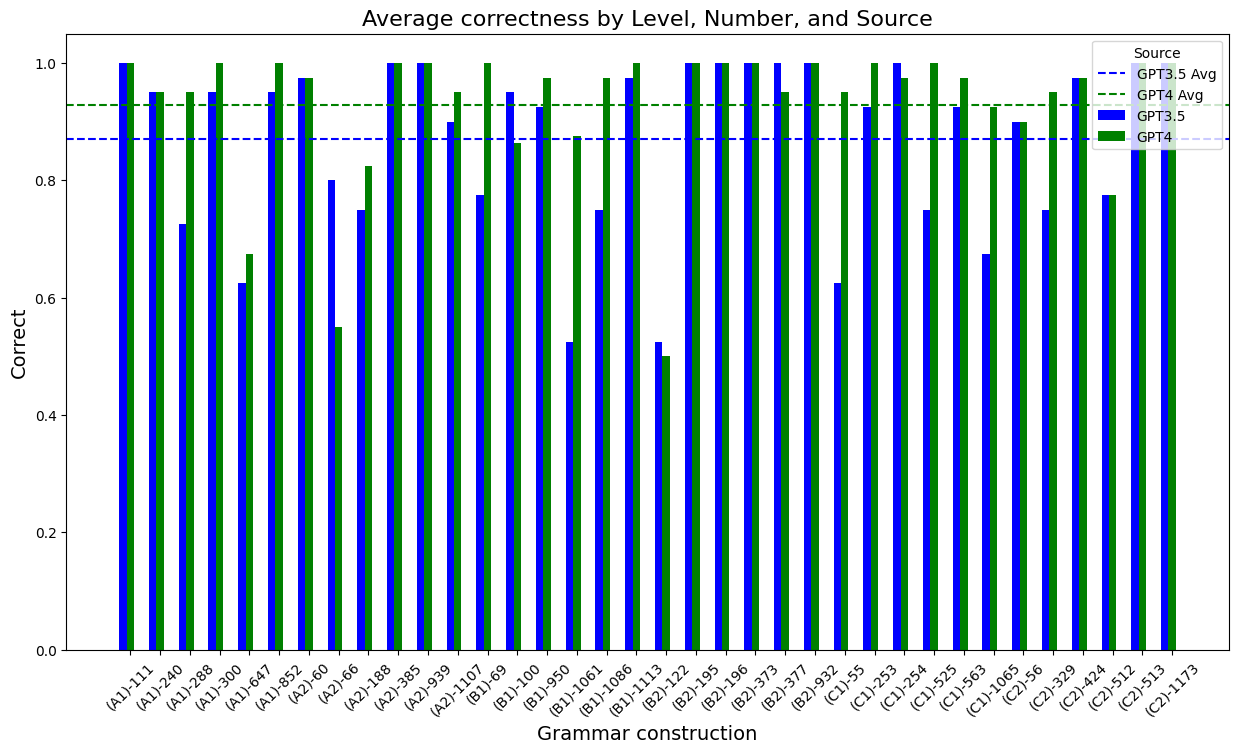

In [6]:
pivot_df = rating_df.pivot_table(index=['Level', '#'], columns='source', values='correct')

x_labels = [f"({level})-{num}" for level, num in pivot_df.index]
n_groups = len(pivot_df.index)


bar_width = 0.25
index = np.arange(n_groups)
positions = [index - bar_width, index, index + bar_width]

fig, ax = plt.subplots(figsize=(15, 8))
colors = {"CoT": "red", "GPT3.5": "blue", "GPT4": "green"}
source_averages = rating_df.groupby('source')['correct'].mean()

for pos, source in zip(positions, pivot_df.columns):
    ax.bar(pos, pivot_df[source], bar_width, label=source, color=colors[source])
    ax.axhline(y=source_averages[source], color=colors[source], linestyle='--', label=f"{source} Avg")


ax.set_xlabel('Grammar construction', fontsize=14)
ax.set_ylabel('Correct', fontsize=14)
ax.set_title('Average correctness by Level, Number, and Source', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(x_labels, rotation=45)
ax.legend(title="Source")

plt.show()

In [13]:
rating_df.groupby(['positive', 'source'])['correct'].mean()

positive  source
0         GPT3.5    0.888889
          GPT4      0.955679
1         GPT3.5    0.852778
          GPT4      0.901662
Name: correct, dtype: float64

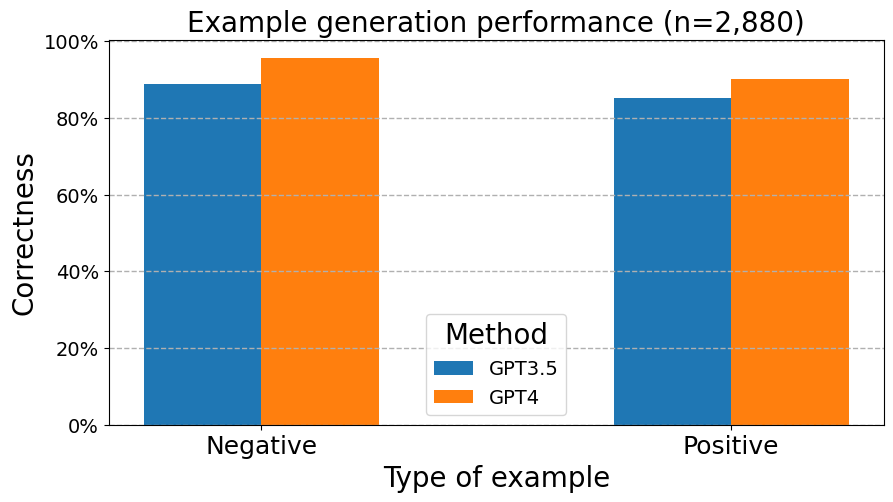

In [9]:
import matplotlib.ticker as mtick
from matplotlib import rcParams
rcParams.update({'font.size': 20, 'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 18,
                 'ytick.labelsize': 14, 'legend.fontsize': 14})

# Creating a pivot table for easier plotting
new_pivot_df = rating_df.pivot_table(index='positive', columns='source', values='correct')

# Number of unique 'Positive' values
n_groups = len(new_pivot_df.index)

# Creating bar positions for each source
index = np.arange(n_groups)
positions = [index - 0.5 * bar_width, index + 0.5 * bar_width]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=1)

for pos, source in zip(positions, new_pivot_df.columns):
    ax.bar(pos, new_pivot_df[source], bar_width, label=source)

# Setting plot details
ax.set_xlabel('Type of example')
ax.set_ylabel('Correctness')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title(f'Example generation performance (n=2,880)')

ax.set_xticks(index)
ax.set_xticklabels(["Negative", "Positive"])
ax.legend(title="Method", loc='lower center')


plt.savefig('../doc/augmentation.pdf', transparent=True, bbox_inches='tight')